In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
import numpy as np
import torch
import torch.nn as nn
from problems import GraphProblem
from policies import RandomPolicy, GreedyPolicy
from planning import WaypointPlanner
from learning import learning_epoch, initialize_with_mds
from collections import deque

In [221]:
import networkx as nx
import copy

In [275]:
# Hyperparameters
n = 100  # number of vertices
p = 0.05  # edge probability
k = 50    # latent dimension
N_T = 50  # number of parallel trajectories/planners
num_epochs = 2000
learn_frequency = 10  # learn every N epochs
learning_rate = 0.01
batch_size = 6400  # batch size for learning
buffer_size = 10000  # replay buffer size

In [276]:
temp = 1.0
c = 1.0
max_waypoints = 10

In [277]:
# Initialize environment
env = GraphProblem(n, p, seed=42)

In [278]:
psi =initialize_with_mds(env, k)

/home/de7281/miniconda3/envs/interp_env/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [279]:
# Initialize learnable parameters
psi_torch = nn.Parameter(torch.tensor(psi, dtype=torch.float32, requires_grad=True))
A_torch = nn.Parameter(torch.eye(k, requires_grad=True))  # Initialize A to identity

# Initialize policy (random at first)
def psi_fun(x: int) -> np.ndarray:
    return psi_torch.detach().numpy()[x, :]

policy = RandomPolicy(env, seed=42)

In [280]:
# Create N_T waypoint planners with random start/goal
planners = []
for i in range(N_T):
    start = np.random.randint(0, n)
    goal = np.random.randint(0, n)
    while goal == start:
        goal = np.random.randint(0, n)
    
    planner = WaypointPlanner(
        start=start,
        goal=goal,
        env=copy.deepcopy(env),  # Each planner gets its own env copy
        policy=policy,
        psi=psi_fun,
        A=A_torch.detach().numpy(),
        waypoint_type='c',  # Use interpolative waypoints
        max_waypoints=max_waypoints,
        c=c,
        T=temp
    )
    planners.append(planner)

print(f"Created {len(planners)} planners")

Created 50 planners


In [281]:
# Initialize replay buffer
replay_buffer = deque(maxlen=buffer_size)

# Training loop
losses = []

for epoch in range(num_epochs):
    # Step each planner forward and collect (state, action, waypoint)
    for planner in planners:
        action, waypoint, done = planner.step()
        
        if action is not None and waypoint is not None:
            # Store (action, waypoint) in replay buffer
            replay_buffer.append((action, waypoint))
        
        # If planner is done, reset with new random start/goal
        if done:
            start = np.random.randint(0, n)
            goal = np.random.randint(0, n)
            while goal == start:
                goal = np.random.randint(0, n)
            planner.reset(start, goal)
    
    # Learning step (every learn_frequency epochs)
    if epoch > 0 and epoch % learn_frequency == 0 and len(replay_buffer) >= batch_size:
        # Sample random batch from replay buffer
        indices = np.random.choice(len(replay_buffer), size=batch_size, replace=False)
        batch = [replay_buffer[i] for i in indices]
        
        # Extract actions and waypoints
        actions = [action for action, waypoint in batch]
        waypoints = torch.tensor([waypoint for action, waypoint in batch], dtype=torch.float32)
        
        # Run learning epoch
        psi_torch, A_torch, policy, loss = learning_epoch(
            psi_torch, A_torch, actions, waypoints, env,
            learning_rate=learning_rate,
            iters_per_epoch=1,
            T=temp
        )
        
        # Update psi_fun and all planners with new policy, psi, A
        def psi_fun(x: int) -> np.ndarray:
            return psi_torch.detach().numpy()[x, :]
        
        A_np = A_torch.detach().numpy()
        
        for planner in planners:
            planner.policy = policy
            planner.psi = psi_fun
            planner.A = A_np
        
        losses.append(loss)  # Track loss
        
        print(f"Epoch {epoch}: Buffer size = {len(replay_buffer)}, "
                  f"Learning updates performed")
        print(f"Current loss: {losses[-1]}")
    

print("Training complete!")

Epoch 130: Buffer size = 6550, Learning updates performed
Current loss: 0.7464427947998047
Epoch 140: Buffer size = 7050, Learning updates performed
Current loss: 0.7294452786445618
Epoch 150: Buffer size = 7550, Learning updates performed
Current loss: 0.720024824142456
Epoch 160: Buffer size = 8050, Learning updates performed
Current loss: 0.7158758044242859
Epoch 170: Buffer size = 8550, Learning updates performed
Current loss: 0.7153855562210083
Epoch 180: Buffer size = 9050, Learning updates performed
Current loss: 0.715416431427002
Epoch 190: Buffer size = 9550, Learning updates performed
Current loss: 0.7123990654945374
Epoch 200: Buffer size = 10000, Learning updates performed
Current loss: 0.7102960348129272
Epoch 210: Buffer size = 10000, Learning updates performed
Current loss: 0.7073638439178467
Epoch 220: Buffer size = 10000, Learning updates performed
Current loss: 0.7053002715110779
Epoch 230: Buffer size = 10000, Learning updates performed
Current loss: 0.70361560583114

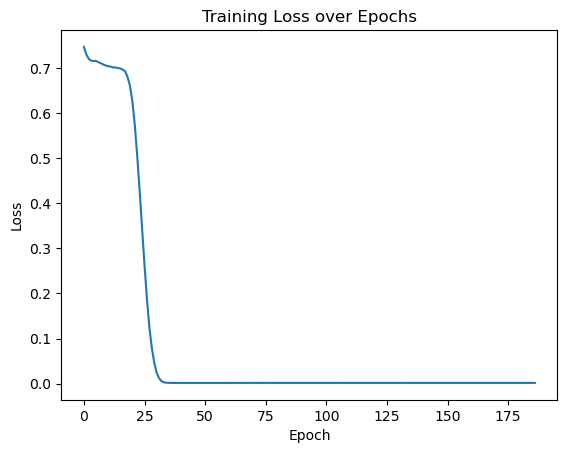

In [282]:
# plot losses
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [283]:
def f_encoder(x: int) -> np.ndarray:
    return psi_fun(x)

def s_encoder(x: int) -> np.ndarray:
    return A_torch.detach().numpy() @ f_encoder(x)

In [284]:
test_policy = GreedyPolicy(copy.deepcopy(env), 
                           s_encoder=s_encoder, 
                           temperature=0.5*temp)

In [285]:
test_policy.get_action(22, f_encoder(50), debug=True)

State: 22, Available actions: [11, 18, 19, 28, 80]
Distances: [10.209776  9.705867  9.965882 10.145558 10.104864]
Logits: [-20.419552 -19.411734 -19.931765 -20.291117 -20.209728]
Probabilities: [0.12921843 0.35400903 0.21045913 0.14692752 0.15938583]
Selected action: 11


np.int64(11)

In [268]:
nx.shortest_path(env.graph, source=22, target=50)

[22, 19, 50]

In [286]:
# Test the learned policy on many start/goal pairs
num_test_pairs = 10
success_count = 0
lens = []
true_lens = []

test_policy = policy

for _ in range(num_test_pairs):
    start = np.random.randint(0, n)
    goal = np.random.randint(0, n)
    while goal == start:
        goal = np.random.randint(0, n)

    true_lens.append(len(nx.shortest_path(env.graph, source=start, target=goal)))
    
    arr = []
    for k in range(10):

        
        test_trajectory = [start]
        max_test_steps = 100
        
        for _ in range(max_test_steps):
            action = test_policy.get_action(test_trajectory[-1], f_encoder(goal))
            # print(action)
            if action is not None:
                test_trajectory.append(action)
            if action == goal:
                break
        
        reached_goal = test_trajectory[-1] == goal
        success_count += int(reached_goal)
        arr.append(len(test_trajectory))
    
    lens.append(arr)
        

In [287]:
print(true_lens)

[5, 3, 4, 5, 4, 4, 3, 5, 3, 5]


In [288]:
print([sum(l)/len(l) for l in lens])

[85.9, 61.5, 76.7, 96.5, 73.6, 82.7, 63.9, 73.2, 52.7, 37.6]


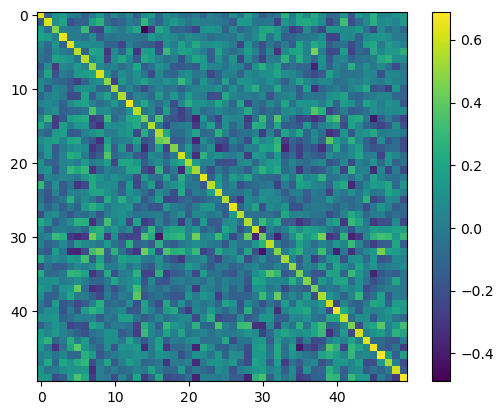

In [210]:
# heatmap of A
import matplotlib.pyplot as plt
plt.imshow(A_torch.detach().numpy(), cmap='viridis')
plt.colorbar()

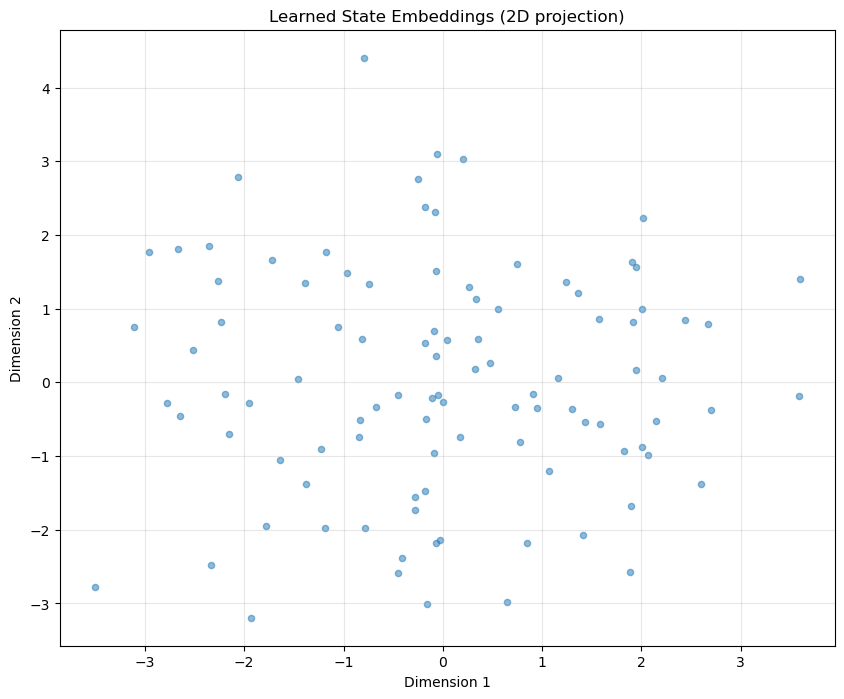

In [212]:
# Visualize learned embeddings (optional - requires matplotlib)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get all embeddings
psi_np = psi_torch.detach().numpy()

# Reduce to 2D for visualization
if k > 2:
    pca = PCA(n_components=2)
    psi_2d = pca.fit_transform(psi_np)
else:
    psi_2d = psi_np[:, :2]

plt.figure(figsize=(10, 8))
plt.scatter(psi_2d[:, 0], psi_2d[:, 1], alpha=0.5, s=20)
plt.title('Learned State Embeddings (2D projection)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, alpha=0.3)
plt.show()